In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Business Understanding

Here we use the Seattle and Boston AirBnB data to answer the following questions:

1. What are the most and least expensive times to rent in each city?
2. What are the most important features which drive the rental prices?  Are these different between the Seattle and Boston data?
3. Are there any strategies a potential renter may take to get a cheaper price on good properties?
4. Are the peak times of year in Seattle and Boston the same?


# Data Understanding

Here we get an overall understanding of the datasets, including:

1. Basic statistics
2. Number of missing values for each attribute
3. Distribution of key fields
4. Visual exploration of relationships between key attributes


### Data Import and Initial Cleanup

In [262]:
# Import the Boston data
bos_list = pd.read_csv('./Data/Boston/listings.csv')
bos_cal  = pd.read_csv('./Data/Boston/calendar.csv')
# bos_rev  = pd.read_csv('./Data/Boston/reviews.csv')

# Import the Seattle data
sea_list = pd.read_csv('./Data/Seattle/listings.csv')
sea_cal  = pd.read_csv('./Data/Seattle/calendar.csv')
# sea_rev  = pd.read_csv('./Data/Seattle/reviews.csv')

# Rename the 'id' field in the listing data to 'listing_id' to match the other tables
bos_list.rename(columns={'id':'listing_id'}, inplace=True)
sea_list.rename(columns={'id':'listing_id'}, inplace=True)

# Set indicies to the 'listing_id' on all dataframes
bos_list.set_index('listing_id', inplace=True)
bos_cal.set_index('listing_id', inplace=True)
# bos_rev.set_index('listing_id', inplace=True)

sea_list.set_index('listing_id', inplace=True)
sea_cal.set_index('listing_id', inplace=True)
# sea_rev.set_index('listing_id', inplace=True)

sea_cal.head()

,date,available,price
listing_id,,,
241032,2016-01-04,t,$85.00
241032,2016-01-05,t,$85.00
241032,2016-01-06,f,NaN
241032,2016-01-07,f,NaN
241032,2016-01-08,f,NaN


In [263]:
# Check to see if the Seattle and Boston listing datasets have the same columns
seattle_not_boston = list(set(sea_list.columns) - set(bos_list.columns))
boston_not_seattle = list(set(bos_list.columns) - set(sea_list.columns))

print("Columns in Seattle set but not in Boston set: ", seattle_not_boston)
print("Columns in Boston set but not in Seattle set: ", boston_not_seattle)

Columns in Seattle set but not in Boston set:  []
Columns in Boston set but not in Seattle set:  ['house_rules', 'interaction', 'access']


In [264]:
# Drop columns not relevant to this analysis
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 
       'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license',
       'license', 'jurisdiction_names', 'instant_bookable',
       'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month']

sea_list.drop(columns=cols_to_drop, inplace=True)
bos_list.drop(columns=cols_to_drop + boston_not_seattle, inplace=True)

sea_list.head()

,host_is_superhost,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy
listing_id,,,,,,,,,,,,,,,,,,,,,
241032,f,West Queen Anne,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,moderate
953595,t,West Queen Anne,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,...,90,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,strict
3308979,f,West Queen Anne,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,...,30,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,strict
7421966,f,West Queen Anne,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,...,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible
278830,f,West Queen Anne,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,...,1125,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,strict


In [265]:
# Check for missing values in Seattle data
missing_vals = sea_list.isnull().sum().sort_values(ascending = False)
missing_vals[missing_vals > 0]

square_feet                    3721
review_scores_checkin           658
review_scores_accuracy          658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
bathrooms                        16
zipcode                           7
bedrooms                          6
host_is_superhost                 2
property_type                     1
beds                              1
dtype: int64

In [266]:
# Check for missing values in Boston data
missing_vals = bos_list.isnull().sum().sort_values(ascending = False)
missing_vals[missing_vals > 0]

square_feet                    3529
review_scores_accuracy          823
review_scores_location          822
review_scores_value             821
review_scores_checkin           820
review_scores_communication     818
review_scores_cleanliness       818
review_scores_rating            813
zipcode                          38
bathrooms                        14
bedrooms                         10
beds                              9
property_type                     3
dtype: int64

In [267]:
# Drop 'square_feet' column since most are missing in both datasets
sea_list.drop(columns=['square_feet'], inplace=True)
bos_list.drop(columns=['square_feet'], inplace=True)

In [268]:
# Convert boolean string fields to boolean
sea_list.replace({'host_is_superhost': {'t': True, 'f': False}}, inplace=True)
bos_list.replace({'host_is_superhost': {'t': True, 'f': False}}, inplace=True)

sea_cal.replace({'available': {'t': True, 'f': False}}, inplace=True)
bos_cal.replace({'available': {'t': True, 'f': False}}, inplace=True)

In [269]:
# Convert date fields to DateTime64
bos_cal.date = pd.to_datetime(bos_cal.date)
bos_rev.date = pd.to_datetime(bos_rev.date)

sea_cal.date = pd.to_datetime(sea_cal.date)
sea_rev.date = pd.to_datetime(sea_rev.date)

In [270]:
# Convert price fields to float
bos_cal.price = bos_cal.price.str.replace('[^\d\.]','', regex=True).astype('float')
sea_cal.price = sea_cal.price.str.replace('[^\d\.]','', regex=True).astype('float')

bos_list.price = bos_list.price.str.replace('[^\d\.]','', regex=True).astype('float')
sea_list.price = sea_list.price.str.replace('[^\d\.]','', regex=True).astype('float')

sea_list.extra_people = sea_list.extra_people.str.replace('[^\d\.]','', regex=True).astype('float')
bos_list.extra_people = bos_list.extra_people.str.replace('[^\d\.]','', regex=True).astype('float')

### Exploratory Data Analysis

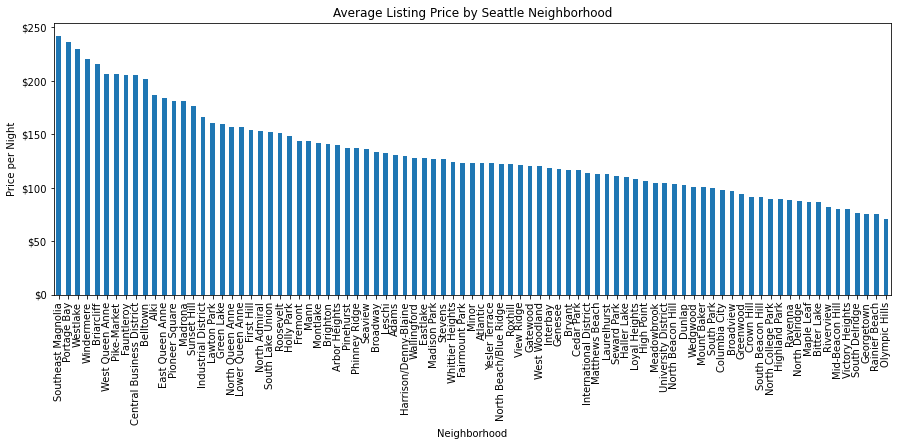

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

_ = sea_cal.join(sea_list[['neighbourhood_cleansed']]) \
       .reset_index() \
       .groupby('neighbourhood_cleansed') \
       .price.mean() \
       .sort_values(ascending=False) \
       .plot(kind='bar', ax=ax)

_ = plt.title("Average Listing Price by Seattle Neighborhood")
_ = plt.xlabel("Neighborhood")
_ = plt.ylabel("Price per Night")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

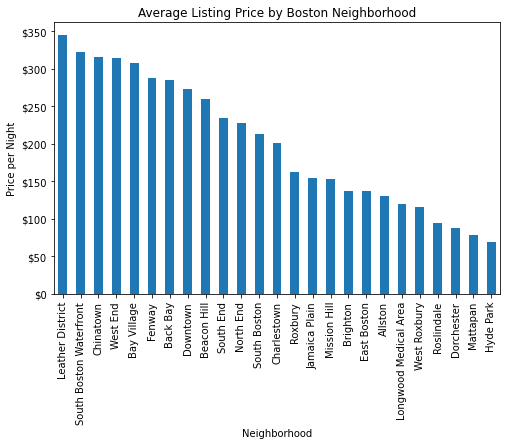

In [280]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

_ = bos_cal.join(bos_list[['neighbourhood_cleansed']]) \
       .reset_index() \
       .groupby('neighbourhood_cleansed') \
       .price.mean() \
       .sort_values(ascending=False) \
       .plot(kind='bar', ax=ax)

_ = plt.title("Average Listing Price by Boston Neighborhood")
_ = plt.xlabel("Neighborhood")
_ = plt.ylabel("Price per Night")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

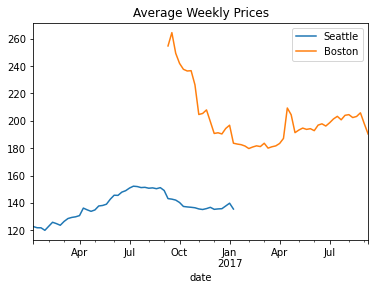

In [184]:
_ = sea_cal \
       .resample('W', on='date') \
       .price.mean() \
       .plot(label='Seattle')

_ = bos_cal \
       .resample('W', on='date') \
       .price.mean() \
       .plot(label='Boston')

_ = plt.title('Average Weekly Prices')

_ = plt.legend()